## Training RESNET-50 on custom acclerometer data of induction motor with different defects

Load the dataset

In [1]:
import pandas as pd

file = "SOON-pEMP/Data/01 - m1_half_shaft_speed_no_mechanical_load.csv"

# Load the dataset
df = df = pd.read_csv(file).astype(float)

# Display the first few rows
print(df.head())


   Timestamp    AccX   AccY     AccZ
0  2141864.0  3624.0 -567.0  17452.0
1  2143688.0  -649.0 -688.0  16899.0
2  2145492.0   -21.0  -66.0  14555.0
3  2147308.0 -1207.0  923.0  12459.0
4  2149108.0   208.0  -16.0  14951.0


Load all the .CSV files as df with labels in a dictionary

In [2]:
import os
import glob
import json


# Define the folder path
folder_path = "SOON-pEMP/Data"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Dictionary to store DataFrames with filenames as keys
dataframes = {}

# Read each CSV file into a DataFrame
for file in csv_files:
    filename = os.path.basename(file).replace(".csv", "")  # Extract filename without extension
    df = pd.read_csv(file).astype(float)  # Read CSV file
    dataframes[filename] = df  # Store in dictionary


Map the class name with a key in JSON file 
eg. m1_electrically_100_ohm_fault_load_0.5Nm_half_speed : 9

In [3]:
# Define the folder path
folder_path = "SOON-pEMP/Data"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Create a class mapping file
class_mapping = {os.path.basename(file).replace(".csv", ""): idx for idx, file in enumerate(csv_files)}

# Save the class mapping
with open("class_mapping.json", "w") as f:
    json.dump(class_mapping, f)


Convert the Acclerometer data to Mel-Spectrogram

In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to convert time-series data to Melspectrogram
def generate_melspectrogram(signal, sr=1000, n_mels=128, n_fft=256,use_db=True):
    if not np.isfinite(signal).all():
        raise ValueError("Signal contains non-finite values.")
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, n_fft=n_fft)
    if use_db:
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibel scale if needed
    return mel_spec


# Compute global maximums to find the max data and normalize the complete dataset
globX = max(df["AccX"].abs().max() for df in dataframes.values()) + 1e-8
globY = max(df["AccY"].abs().max() for df in dataframes.values()) + 1e-8
globZ = max(df["AccZ"].abs().max() for df in dataframes.values()) + 1e-8

# Define window size and step size
window_size = 1000  # Fixed window size
step_size = window_size // 2  # 50% overlap

# Generate spectrogram images
data_spectrograms = {}

for name, df in dataframes.items():
    # Normalize using global values
    signals = [df["AccX"].values / globX, df["AccY"].values / globY, df["AccZ"].values / globZ]
    signals = [np.nan_to_num(sig) for sig in signals]  # Ensure no NaN values
    
    # Ensure the data fits into windows by padding if necessary
    num_samples = len(signals[0])
    pad_size = (window_size - (num_samples % window_size)) % window_size
    signals = [np.pad(sig, (0, pad_size), mode='constant') for sig in signals]
    
    spectrogram_images = {}
    for idx, start in enumerate(range(0, len(signals[0]) - window_size + 1, step_size)):
        windowed_signals = [sig[start:start + window_size] for sig in signals]
        mel_spectrograms = [generate_melspectrogram(sig) for sig in windowed_signals]
        
        # Stack to form a 3-channel image
        mel_spectrogram_img = np.stack(mel_spectrograms, axis=-1)
        
        # Store in dictionary
        spectrogram_images[f"im_{idx}"] = mel_spectrogram_img
    
    # Store per dataset
    data_spectrograms[name] = spectrogram_images

In [5]:
# Check the image dataset cretaed from acclerometer data
for dataset_name, spectrograms in data_spectrograms.items():
    print(f"Dataset: {dataset_name}")
    # Calculate and print the total number of images for each dataset
    num_images = len(spectrograms)
    print(f"  Total Images: {num_images}")

Dataset: 18 - m1_load_0.5Nm_m2_mechanically_imbalanced_on_background_half_speed
  Total Images: 209
Dataset: 05 - m1_mechanically_imbalanced_load_0.5Nm_half_speed
  Total Images: 303
Dataset: 06 - m1_electrically_50_ohm_fault_half_speed
  Total Images: 209
Dataset: 22 - m1_electrically_100_ohm_fault_m2_mechanically_imbalanced_half_speed
  Total Images: 209
Dataset: 07 - m1_electrically_100_ohm_fault_half_speed
  Total Images: 203
Dataset: 17 - m1_mechanically_imbalanced_with_m2_mechanicaly_imbalanced_on_background_half_speed
  Total Images: 311
Dataset: 23 - m1_electrically_100_ohm_fault_load_0.5Nm_m2_mechanically_imbalanced_half_speed
  Total Images: 217
Dataset: 20 - m1_electrically_50_ohm_fault_m2_imbalanced_on_background_half_speed
  Total Images: 223
Dataset: 30 - m1_mechanically_imbalanced_electrically_150_ohm_fault_m2_imbalanced_on_background_rotated_half_speed
  Total Images: 203
Dataset: 10 - m1_electrically_100_ohm_fault_load_0.5Nm_half_speed
  Total Images: 207
Dataset: 13 -

Visualize the Mel spectrogram for one Window

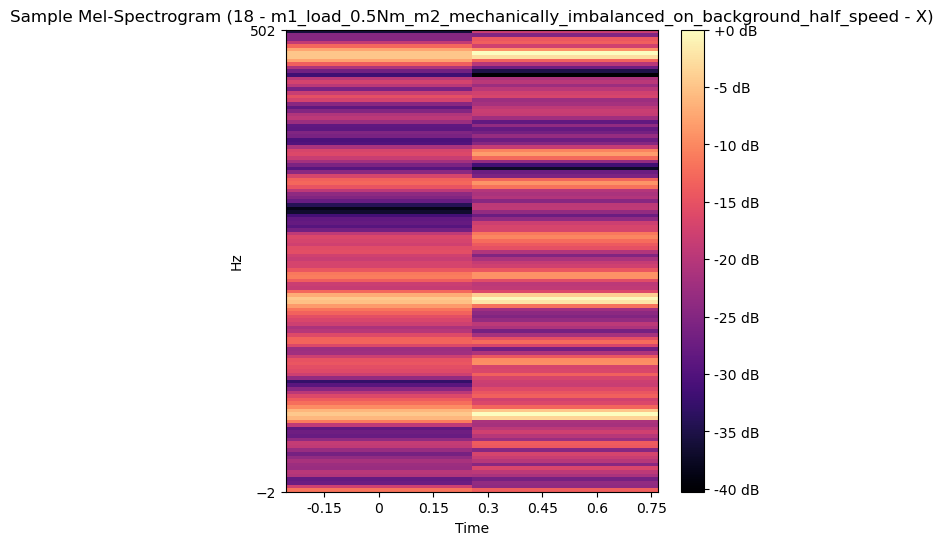

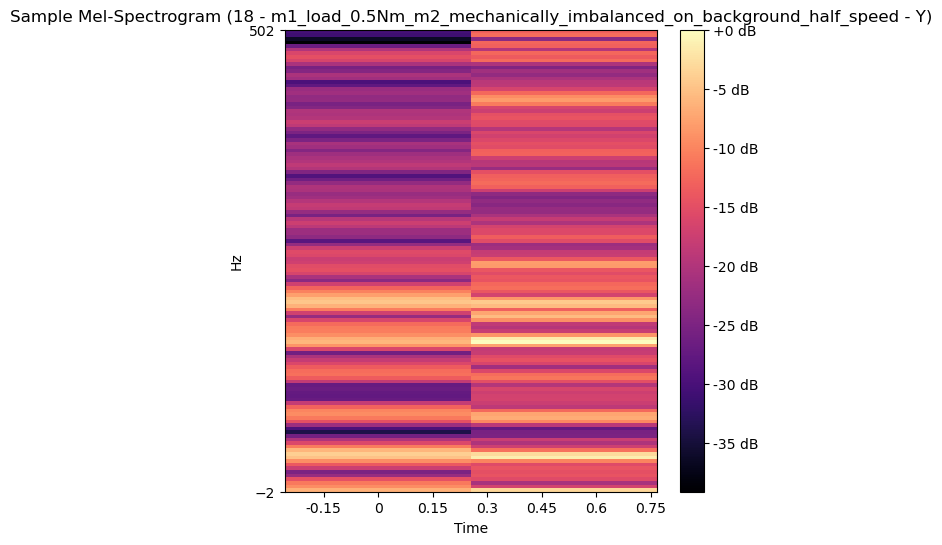

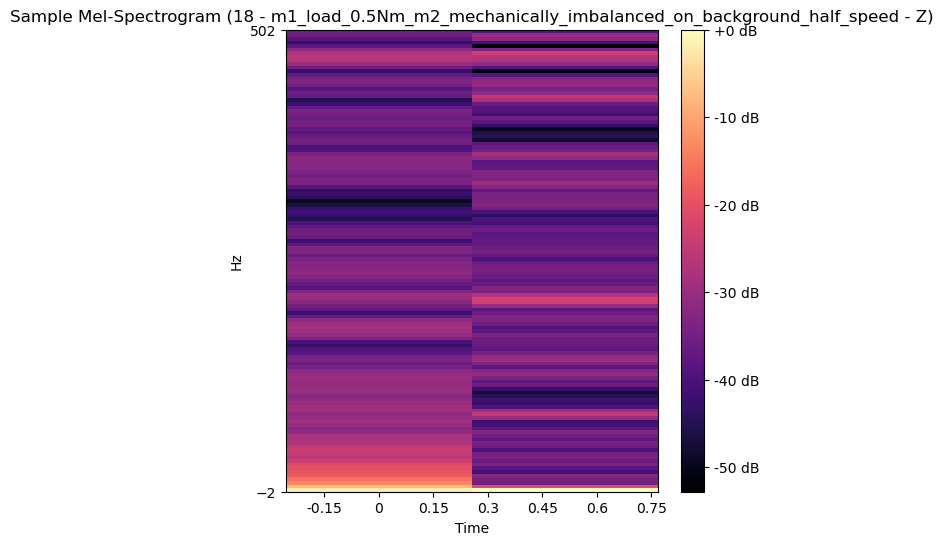

In [6]:
# Display Mel spectrograms for X, Y, and Z separately
sample_key = next(iter(data_spectrograms))  # Pick the first dataset
sample_img_key = next(iter(data_spectrograms[sample_key]))  # Pick the first spectrogram
sample_img = data_spectrograms[sample_key][sample_img_key]

channels = ['X', 'Y', 'Z']  # Labels for the channels

for i in range(3):  # Iterate through the three channels (X, Y, Z)
    plt.figure(figsize=(6, 6))
    librosa.display.specshow(sample_img[:, :, i], sr=1000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Sample Mel-Spectrogram ({sample_key} - {channels[i]})')
    plt.show()

Visualize the Mel spectrogram for one example defect

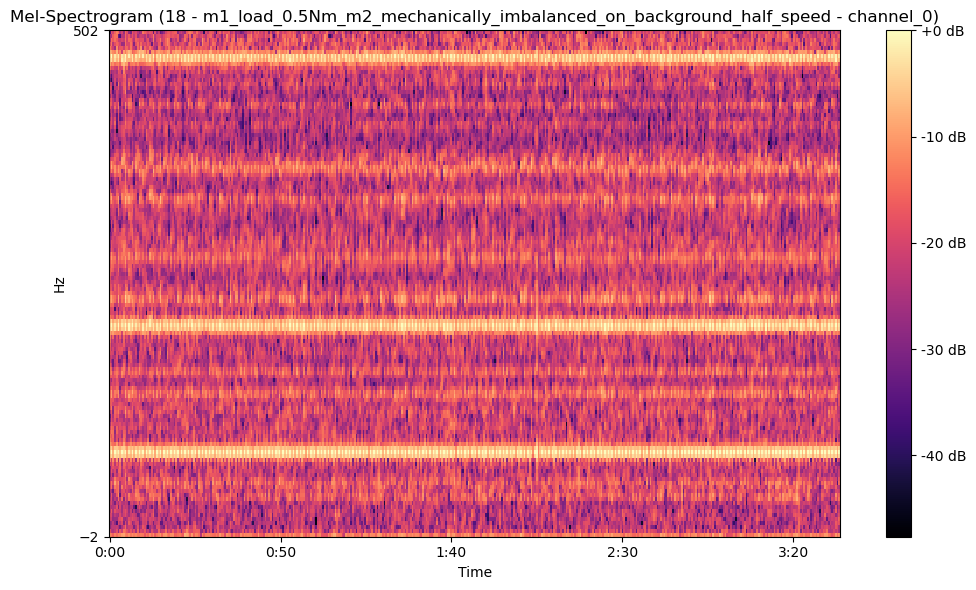

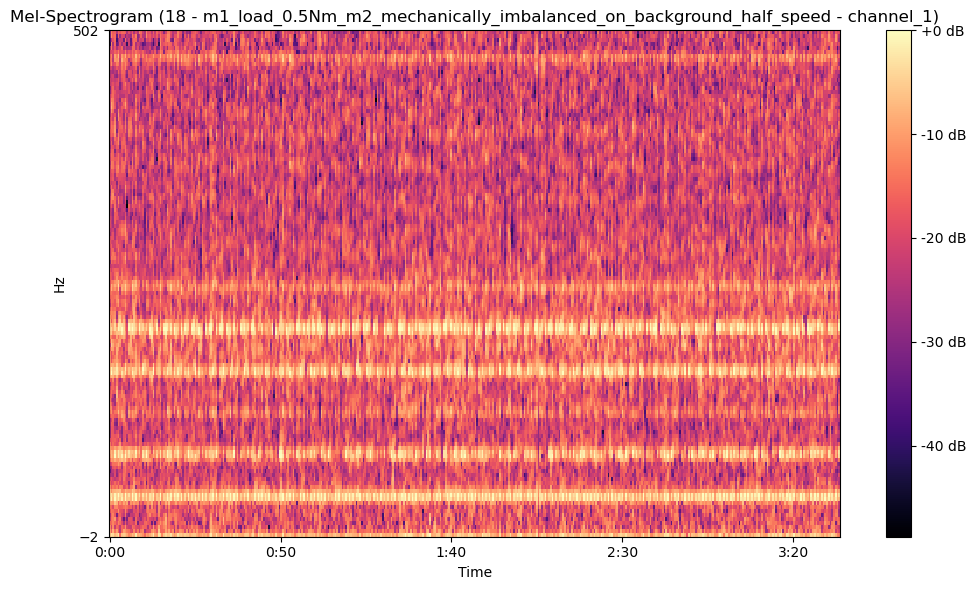

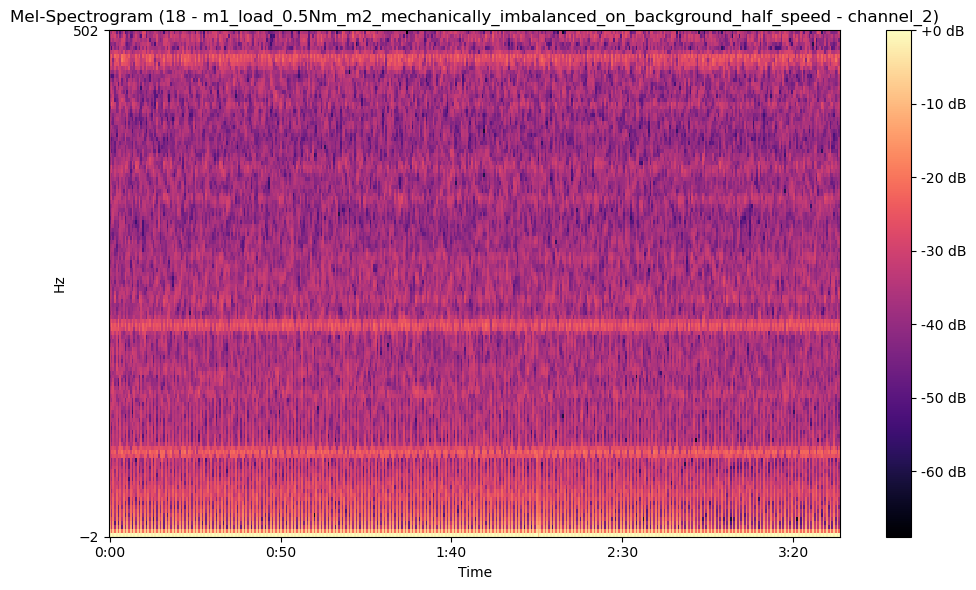

In [7]:
# Combine spectrograms for ONE dataset
combined_spectrograms = {}
sample_name = next(iter(data_spectrograms)) # Get the name of the first dataset
spectrogram_images = data_spectrograms[sample_name] # Get the spectrogram images for the first dataset

combined_spectrograms[sample_name] = {}
for channel_idx in range(3):  # Iterate through channels (X, Y, Z)
    channel_spectrograms = []
    for img_key in sorted(spectrogram_images.keys()): # Order the keys
        channel_spectrograms.append(spectrogram_images[img_key][:, :, channel_idx])
    combined_spectrogram = np.concatenate(channel_spectrograms, axis=1)  # Concatenate along time axis (axis=1)
    combined_spectrograms[sample_name][f"channel_{channel_idx}"] = combined_spectrogram

# Now, display the combined spectrogram for the selected dataset:
combined_channel_spectrograms = combined_spectrograms[sample_name]
for channel_name, combined_spectrogram in combined_channel_spectrograms.items():
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    librosa.display.specshow(combined_spectrogram, sr=1000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram ({sample_name} - {channel_name})')
    plt.tight_layout()
    plt.show()

Preparing the dataset

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import json
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset, random_split


# Load class mapping
with open("class_mapping.json", "r") as f:
    class_mapping = json.load(f)

# Convert class names to integer labels
def get_label(class_name):
    return class_mapping[class_name]

# Assume data_spectrograms is available
all_images = []
all_labels = []
for class_name, spectrograms in data_spectrograms.items():
    label = get_label(class_name)
    for img_key, img in spectrograms.items():
        all_images.append(img)
        all_labels.append(label)

# Create dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(self.images[idx], dtype=np.float32)
        label = self.labels[idx]
        # Convert to channel-first format (C, H, W) for PyTorch
        image = torch.tensor(image).permute(2, 0, 1)  # assuming images are (H, W, C)
        return image, label



dataset = SpectrogramDataset(all_images, all_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



RESNET-50 training 3 ways of comparing
1. Train the whole architecture starting from the pretrained weights
2. First and last layer re-trained by keeping the inside architecture frozen
3. Train the whole architecture by randomly assigning the weights. 

Training ResNet-50 (All Layers, Pretrained):
Epoch [1/10], Loss: 1.5979
Epoch [2/10], Loss: 0.8149
Epoch [3/10], Loss: 0.6385
Epoch [4/10], Loss: 0.5967
Epoch [5/10], Loss: 0.5189
Epoch [6/10], Loss: 0.4689
Epoch [7/10], Loss: 0.4500
Epoch [8/10], Loss: 0.4128
Epoch [9/10], Loss: 0.3874
Epoch [10/10], Loss: 0.3752
Pretrained All Layers -> Accuracy: 80.13% | Precision: 0.8458 | Recall: 0.8013 | F1 Score: 0.7898

Training ResNet-50 (First/Last, Frozen Inner):
Epoch [1/10], Loss: 2.6843
Epoch [2/10], Loss: 2.0193
Epoch [3/10], Loss: 1.6815
Epoch [4/10], Loss: 1.4987
Epoch [5/10], Loss: 1.4449
Epoch [6/10], Loss: 1.4132
Epoch [7/10], Loss: 1.2917
Epoch [8/10], Loss: 1.2696
Epoch [9/10], Loss: 1.2361
Epoch [10/10], Loss: 1.2280


/home/ashutosh/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Frozen Inner Layers -> Accuracy: 57.14% | Precision: 0.6190 | Recall: 0.5714 | F1 Score: 0.5396

Training ResNet-50 (All Layers, Random Weights):
Epoch [1/10], Loss: 2.0622
Epoch [2/10], Loss: 1.0619
Epoch [3/10], Loss: 0.8718
Epoch [4/10], Loss: 0.7265
Epoch [5/10], Loss: 0.6426
Epoch [6/10], Loss: 0.5931
Epoch [7/10], Loss: 0.5374
Epoch [8/10], Loss: 0.6700
Epoch [9/10], Loss: 0.5291
Epoch [10/10], Loss: 0.5409
Random Weights All Layers -> Accuracy: 73.90% | Precision: 0.8196 | Recall: 0.7390 | F1 Score: 0.7140


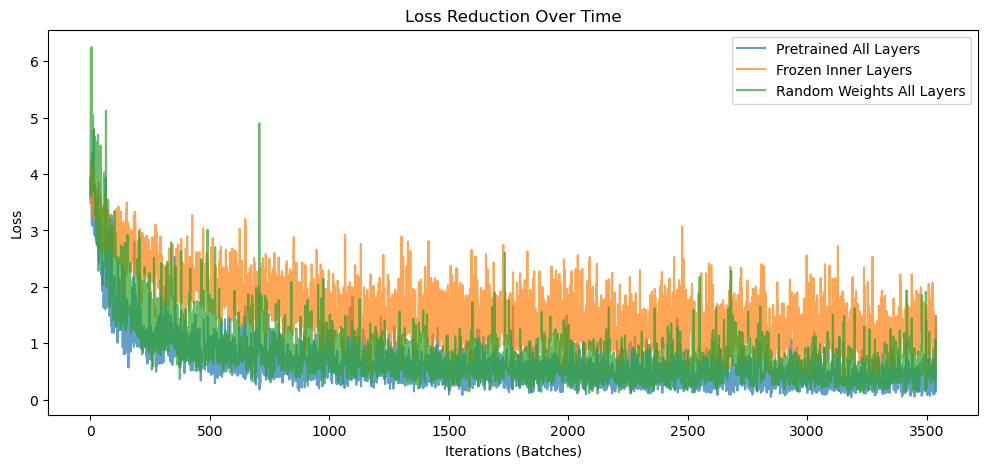

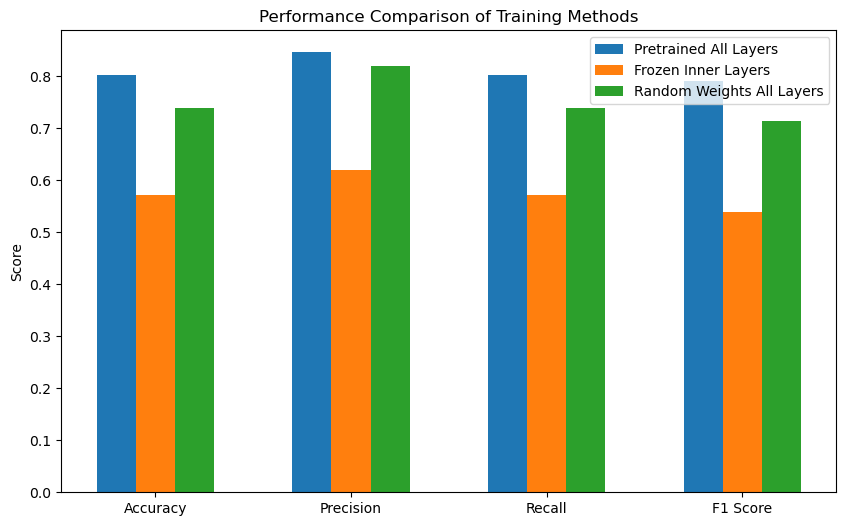

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset, random_split

def train_and_evaluate(model, train_loader, test_loader, num_epochs, train_all=True, label=""):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    batch_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batch_losses.append(loss.item())  # Store per batch loss
        
        train_losses.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"{label} -> Accuracy: {accuracy * 100:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
    
    return train_losses, batch_losses, accuracy, precision, recall, f1

# Store metrics for comparison
results = {}

# --- 1. Train the whole architecture (pretrained weights) ---
print("Training ResNet-50 (All Layers, Pretrained):")
model_pretrained = models.resnet50(weights="IMAGENET1K_V1")  # Updated weights argument
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, len(class_mapping))
train_losses_pretrained, batch_losses_pretrained, acc_pretrained, prec_pretrained, rec_pretrained, f1_pretrained = train_and_evaluate(model_pretrained, train_loader, test_loader, num_epochs=10, label="Pretrained All Layers")
torch.save(model_pretrained.state_dict(), "resnet50_pretrained.pth")
results["Pretrained All Layers"] = (acc_pretrained, prec_pretrained, rec_pretrained, f1_pretrained)

# --- 2. First and last layer re-trained (inner frozen) ---
print("\nTraining ResNet-50 (First/Last, Frozen Inner):")
model_frozen_inner = models.resnet50(weights="IMAGENET1K_V1")
model_frozen_inner.fc = nn.Linear(model_frozen_inner.fc.in_features, len(class_mapping))
for param in model_frozen_inner.parameters():
    param.requires_grad = False
for param in model_frozen_inner.layer1.parameters():  
    param.requires_grad = True
for param in model_frozen_inner.fc.parameters():
    param.requires_grad = True
train_losses_frozen_inner, batch_losses_frozen_inner, acc_frozen, prec_frozen, rec_frozen, f1_frozen = train_and_evaluate(model_frozen_inner, train_loader, test_loader, num_epochs=10, label="Frozen Inner Layers")
torch.save(model_frozen_inner.state_dict(), "resnet50_frozen_inner.pth")
results["Frozen Inner Layers"] = (acc_frozen, prec_frozen, rec_frozen, f1_frozen)

# --- 3. Train the whole architecture (random weights) ---
print("\nTraining ResNet-50 (All Layers, Random Weights):")
model_random = models.resnet50(weights=None)  # Random weights
model_random.fc = nn.Linear(model_random.fc.in_features, len(class_mapping))
train_losses_random, batch_losses_random, acc_random, prec_random, rec_random, f1_random = train_and_evaluate(model_random, train_loader, test_loader, num_epochs=10, label="Random Weights All Layers")
torch.save(model_random.state_dict(), "resnet50_random.pth")
results["Random Weights All Layers"] = (acc_random, prec_random, rec_random, f1_random)

# --- Loss Curve Plots ---
plt.figure(figsize=(12, 5))
plt.plot(batch_losses_pretrained, label="Pretrained All Layers", alpha=0.7)
plt.plot(batch_losses_frozen_inner, label="Frozen Inner Layers", alpha=0.7)
plt.plot(batch_losses_random, label="Random Weights All Layers", alpha=0.7)
plt.xlabel("Iterations (Batches)")
plt.ylabel("Loss")
plt.title("Loss Reduction Over Time")
plt.legend()
plt.show()

# --- Performance Comparison Bar Chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = np.array([list(results[k]) for k in results.keys()])
bar_width = 0.2
x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
for i, (key, val) in enumerate(results.items()):
    plt.bar(x + i * bar_width, val, width=bar_width, label=key)
plt.xticks(x + bar_width, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison of Training Methods")
plt.legend()
plt.show()


Analyzing the loss by doing moving average on a window size of 50

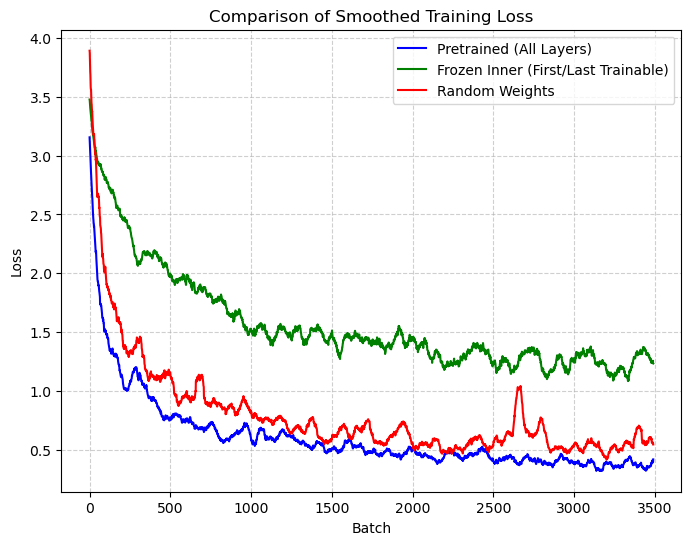

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute moving average (smoothing)
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Define smoothing window size
window_size = 50

# Compute moving averages
smoothed_losses_pretrained = moving_average(batch_losses_pretrained, window_size)
smoothed_losses_frozen_inner = moving_average(batch_losses_frozen_inner, window_size)
smoothed_losses_random = moving_average(batch_losses_random, window_size)

# Plot smoothed training losses
plt.figure(figsize=(8, 6))

plt.plot(smoothed_losses_pretrained, label="Pretrained (All Layers)", color="blue")
plt.plot(smoothed_losses_frozen_inner, label="Frozen Inner (First/Last Trainable)", color="green")
plt.plot(smoothed_losses_random, label="Random Weights", color="red")

plt.title("Comparison of Smoothed Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


/tmp/ipykernel_127179/3325766829.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))  # Load weights


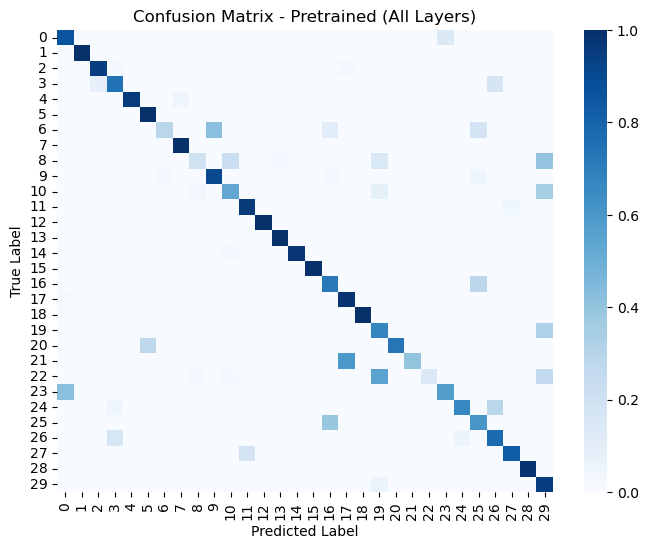

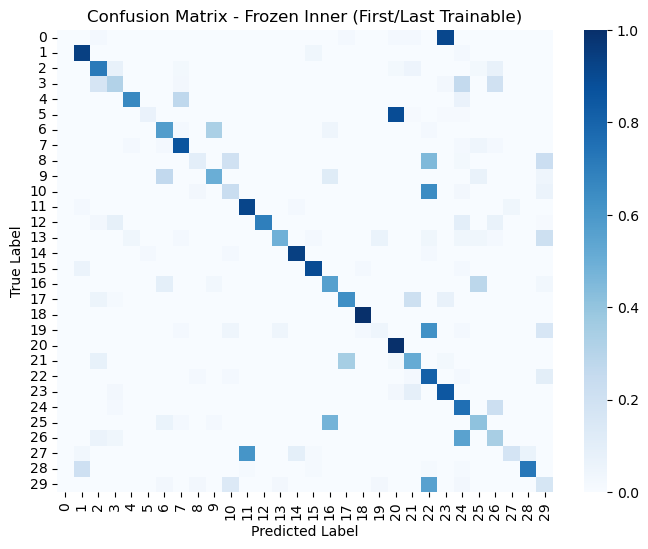

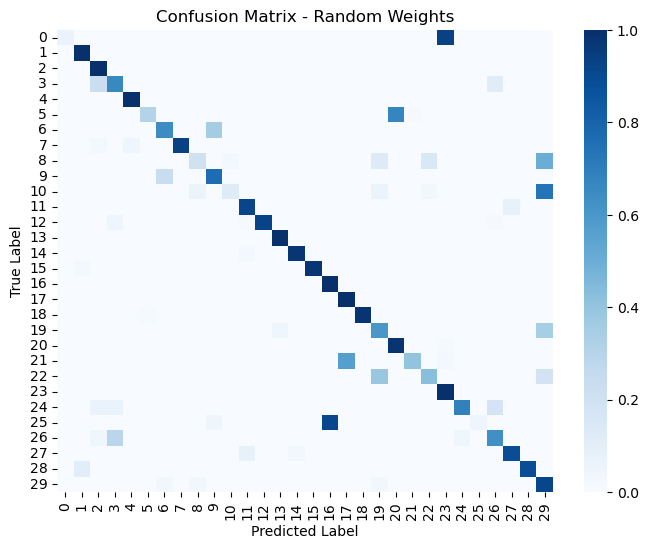

In [12]:
import torch
import torchvision.models as models
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

# Load class mapping
with open("class_mapping.json", "r") as f:
    class_mapping = json.load(f)
inverse_mapping = {v: k for k, v in class_mapping.items()}  # Index to class name

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load a model with given weights
def load_model(weights_path):
    model = models.resnet50(weights=None)  # Start with a base ResNet-50
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_mapping))  # Adjust for the number of classes
    model.load_state_dict(torch.load(weights_path, map_location=device))  # Load weights
    model = model.to(device)
    model.eval()
    return model

# Load all 3 models
model_pretrained = load_model("resnet50_pretrained.pth")
model_frozen_inner = load_model("resnet50_frozen_inner.pth")
model_random = load_model("resnet50_random.pth")

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to compute and return a normalized confusion matrix
def compute_confusion_matrix(model):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize rows

    return cm_normalized

# Compute confusion matrices for each model
confusion_matrices = {
    "Pretrained (All Layers)": compute_confusion_matrix(model_pretrained),
    "Frozen Inner (First/Last Trainable)": compute_confusion_matrix(model_frozen_inner),
    "Random Weights": compute_confusion_matrix(model_random)
}

# Plot confusion matrices separately
for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt=".2f", cmap="Blues", xticklabels=[str(i) for i in range(len(inverse_mapping))], 
                yticklabels=[str(i) for i in range(len(inverse_mapping))])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


Confusion matrix 

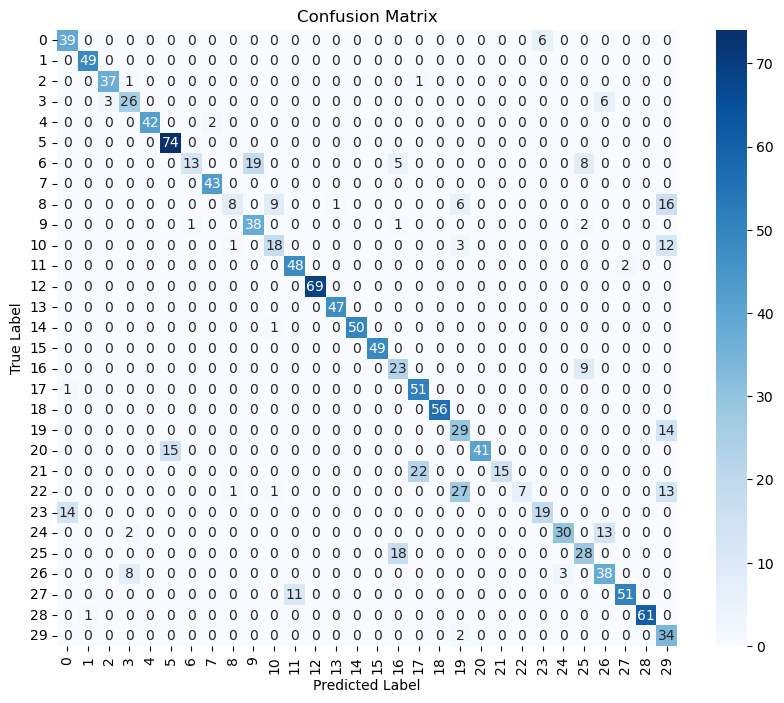

In [19]:
import torch
import torchvision.models as models
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None) # If you are loading your own weights
model.fc = torch.nn.Linear(model.fc.in_features, 30)
model.load_state_dict(torch.load("resnet50_pretrained.pth", map_location=device, weights_only=True)) # weights_only=True added
model = model.to(device)
model.eval()


# Load class mapping
with open("class_mapping.json", "r") as f:
    class_mapping = json.load(f)
inverse_mapping = {v: k for k, v in class_mapping.items()}


# Create a DataLoader for the test dataset (same as in previous code)
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to compute confusion matrix on test set
def compute_confusion_matrix():
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    # Modify xticklabels and yticklabels to show only class indices (0, 1, 2, ...)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(len(inverse_mapping))], 
                yticklabels=[str(i) for i in range(len(inverse_mapping))])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Compute and visualize confusion matrix
compute_confusion_matrix()


Ways to use the pretrained model

In [20]:
import torch
import torchvision.models as models
import numpy as np
import pandas as pd
import librosa
import json


# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None) # If you are loading your own weights
model.fc = torch.nn.Linear(model.fc.in_features, 30)
model.load_state_dict(torch.load("resnet50_trained.pth", map_location=device, weights_only=True)) # weights_only=True added
model = model.to(device)
model.eval()

# Load class mapping
with open("class_mapping.json", "r") as f:
    class_mapping = json.load(f)
inverse_mapping = {v: k for k, v in class_mapping.items()}


# Predict function
def predict(df):
     
    signals = [df["AccX"].values, df["AccY"].values, df["AccZ"].values]
    signals = [librosa.util.normalize(sig) for sig in signals]
    

    num_samples = len(signals[0])
    pad_size = (window_size - (num_samples % window_size)) % window_size
    signals = [np.pad(sig, (0, pad_size), mode='constant') for sig in signals]
    
    predictions = []
    for start in range(0, len(signals[0]) - window_size + 1, step_size):
        windowed_signals = [sig[start:start + window_size] for sig in signals]
        mel_spectrograms = [generate_melspectrogram(sig) for sig in windowed_signals]
        mel_spectrogram_img = np.stack(mel_spectrograms, axis=-1)
        image_tensor = torch.tensor(mel_spectrogram_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            predictions.append(predicted_class)
    
    final_prediction = max(set(predictions), key=predictions.count)  # Majority voting
    return inverse_mapping[final_prediction]


Example usage of the model 

In [21]:
# Example usage
csv_file_path = "SOON-pEMP/Data/10 - m1_electrically_100_ohm_fault_load_0.5Nm_half_speed.csv" # Replace with actual CSV file
df = pd.read_csv(csv_file_path).astype(float)

sample_size = 5000 # Take 5000 time step data from the dataset
# Generate a random start index. Ensure we can take a sample of sample_size.
start_index = np.random.randint(0, len(df) - sample_size + 1)
# Extract the sample
sampled_data = df.iloc[start_index:start_index + sample_size]

# Extract true class from filename (improved)
base_filename = os.path.basename(csv_file_path)
true_class = base_filename.split("Data/")[0] # Split by " - " and take the second part

predicted_class = predict(sampled_data)
print(f"Predicted Class: {predicted_class}")
print(f"True Class :{true_class}")

/home/ashutosh/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=50
  warnings.warn(


Predicted Class: 06 - m1_electrically_50_ohm_fault_half_speed
True Class :10 - m1_electrically_100_ohm_fault_load_0.5Nm_half_speed.csv
